### 0. Module Import

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.stats import sem
from scipy.stats import pearsonr
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

### 1. Data Import

In [157]:
df = pd.read_csv('data_retention.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Employee Number             1470 non-null   int64 
 1   Retention                   1470 non-null   int64 
 2   Age                         1470 non-null   int64 
 3   Gender                      1470 non-null   int64 
 4   Education                   1470 non-null   int64 
 5   Marital Status              1470 non-null   object
 6   Distance From Home          1470 non-null   int64 
 7   Hourly Rate                 1470 non-null   int64 
 8   Daily Rate                  1470 non-null   int64 
 9   Monthly Rate                1470 non-null   int64 
 10  Monthly Income              1470 non-null   int64 
 11  Percent Salary Hike         1470 non-null   int64 
 12  Education Field             1470 non-null   object
 13  Department                  1470 non-null   obje

In [158]:
# Renaming columns - Lowercase and underscore column names
df = df.rename(columns={'BusinessTravel':'Business Travel'})

import re
df = df.rename(columns=lambda col: re.sub(r"\s+", "_", col.lower()))

# Drop 'employee_number' from the Table
df = df.drop(columns=['employee_number', 'standard_hours'])

df.head()

,retention,age,gender,education,marital_status,distance_from_home,hourly_rate,daily_rate,monthly_rate,monthly_income,...,relationship_satisfaction,environment_satisfaction,work_life_balance,num_companies_worked,total_working_years,years_at_company,job_level,years_since_last_promotion,years_in_current_role,years_with_current_manager
0,0,41,0,2,Single,1,94,1102,19479,5993,...,1,2,1,8,8,6,2,0,4,5
1,1,49,1,1,Married,8,61,279,24907,5130,...,4,3,3,1,10,10,2,1,7,7
2,0,37,1,2,Single,2,92,1373,2396,2090,...,2,4,3,6,7,0,1,0,0,0
3,1,33,0,4,Married,3,56,1392,23159,2909,...,3,4,3,1,8,8,1,3,7,0
4,1,27,1,1,Married,2,40,591,16632,3468,...,4,1,3,9,6,2,1,2,2,2


### 2. Logistic Regression

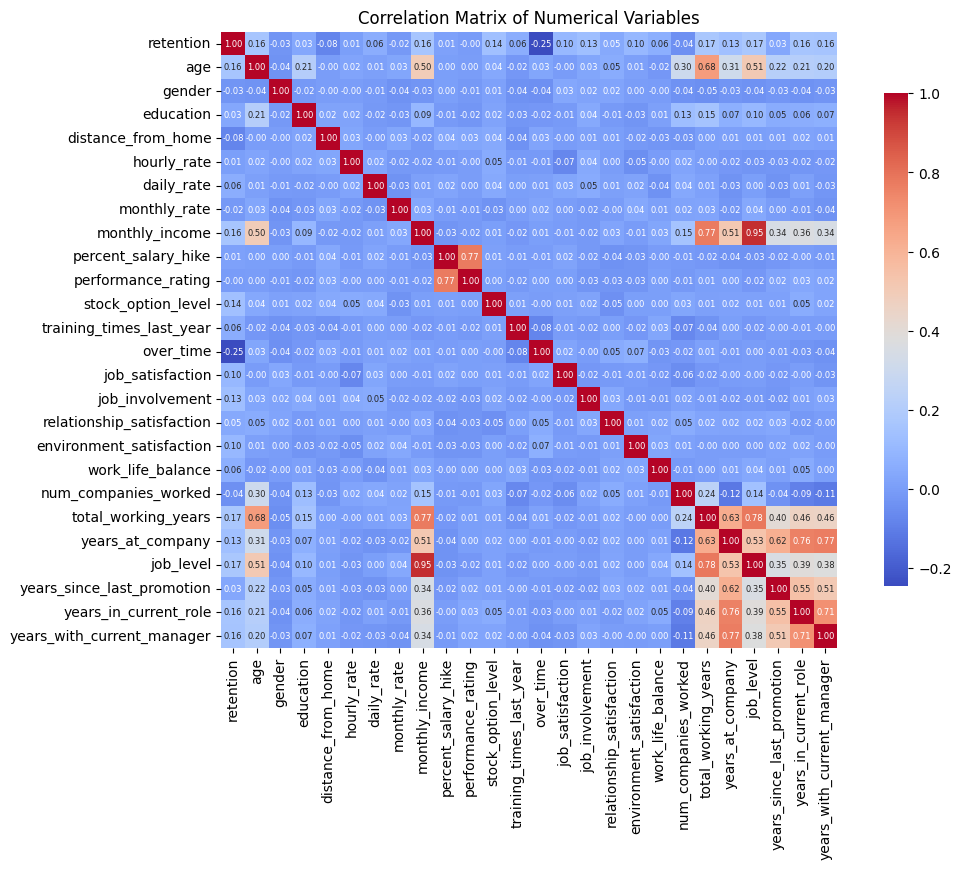

In [159]:
# Correlation Matrix
numerical_data = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numerical_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, 
            annot_kws={"size": 6})
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [160]:
status_counts = df['marital_status'].value_counts()

print(status_counts)

print("\n")
job_count = df['job_role'].value_counts()

print(job_count)

marital_status
Married     673
Single      470
Divorced    327
Name: count, dtype: int64


job_role
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: count, dtype: int64


In [161]:
# Drop Salary Variables
df = df.drop(columns=['hourly_rate', 'monthly_rate', 'daily_rate'])

# Create 'avrg_years_per_comp'
df['num_companies_worked'] += 1
df['avrg_years_per_comp'] = df['total_working_years'] / df['num_companies_worked']

# Drop Experience Variables
df = df.drop(columns=['total_working_years', 'years_with_current_manager', 'years_at_company', 'job_level', 'performance_rating'])

# Continuous Variables
cont = df.select_dtypes(include=[np.number])

cont = cont.drop(columns = ['gender', 'education', 'stock_option_level', 'over_time', 'job_satisfaction',
                            'job_involvement', 'relationship_satisfaction', 'environment_satisfaction', 'work_life_balance', 'avrg_years_per_comp'])

# Mapping Categorical Variables
travel_mapping = {
    'Travel_Rarely': 1,
    'Travel_Frequently': 2,
    'Non-Travel': 0
}

df['business_travel'] = df['business_travel'].map(travel_mapping).infer_objects()

# Create correct_field_of_study
def determine_correct_field(row):
    education = row['education_field']
    job = row['job_role']

    if education == "Other":
        return 1
    elif education in ["Life Science", "Technical Degree", "Medical"] and row['department'] == "R&D":
        return 1
    elif education == "Human Resources" and row['department'] == "Human Resources":
        return 1
    elif education == "Marketing" and row['department'] == "Sales":
        return 1
    elif job == "Manager":
        return 1
    else:
        return 0

df['correct_field_of_study'] = df.apply(determine_correct_field, axis=1)

# Encode 'job_role' and 'marital_status' variable and Drop 'department' and 'education_field'
df = pd.get_dummies(df, columns=['marital_status'], prefix='status')
df = pd.get_dummies(df, columns=['job_role'], prefix='role')

# Drop the specific dummy columns for 'Married' and 'Sales Executive'
df = df.drop(columns=['status_Married', 'role_Sales Executive'], errors='ignore')

df = df.drop(columns=['department', 'education_field'])
df = df.astype(int)

df = df.rename(columns=lambda col: re.sub(r"\s+", "_", col.lower()))

In [162]:
# Test for Normality
def shapiro_test_for_normality(column):
    statistic, p_value = shapiro(column)

    alpha = 0.05

    is_normal = p_value > alpha

    return statistic, round(p_value, 2), is_normal

results_list = []

for column in cont.columns:
    statistic, p_value, is_normal = shapiro_test_for_normality(cont[column])
    results_list.append({
        'Column': column,
        'Shapiro Statistic': statistic,
        'P-value': p_value,
        'Is Normal': is_normal
    })

results_df = pd.concat([pd.DataFrame([result]) for result in results_list], ignore_index=True)
results_df

,Column,Shapiro Statistic,P-value,Is Normal
0,retention,0.442078,0.0,False
1,age,0.977449,0.0,False
2,distance_from_home,0.861588,0.0,False
3,monthly_income,0.827907,0.0,False
4,percent_salary_hike,0.900606,0.0,False
5,training_times_last_year,0.895094,0.0,False
6,num_companies_worked,0.848775,0.0,False
7,years_since_last_promotion,0.703728,0.0,False
8,years_in_current_role,0.896187,0.0,False


In [163]:
# Scale Variables to [0, 1] range
scaler = MinMaxScaler()

columns_to_scale = [
    'age', 
    'distance_from_home', 
    'monthly_income', 
    'percent_salary_hike', 
    'training_times_last_year', 
    'num_companies_worked', 
    'years_since_last_promotion', 
    'years_in_current_role'
]

df_scaled = df.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

In [164]:
# Logistic Regression Model
X = df_scaled.drop(columns=['retention'])
y = df_scaled['retention']

# Split the Dataset into Training and Testing Sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sm = sm.add_constant(X_train)

# Initialize the Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)

# Fit the Model to the Training Data
logistic_model.fit(X_train, y_train)

# Make Predictions on the Test Set
y_pred = logistic_model.predict(X_test)
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]

# Evaluate the Model's Performance
accuracy = accuracy_score(y_test, y_pred)
accuracy_df = pd.DataFrame({'Accuracy': [accuracy]})

confusion = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion, columns=['Predicted No', 'Predicted Yes'], index=['Actual No', 'Actual Yes'])

report = classification_report(y_test, y_pred, output_dict=True)
classification_df = pd.DataFrame(report).transpose()

display(accuracy_df)

print('Confusion Matrix:')
display(conf_matrix_df)

print('Classification Report:')
display(classification_df)

# Logistic Model Result
logistic_model = sm.Logit(y_train, X_train_sm)
result = logistic_model.fit()

result.summary()

,Accuracy
0,0.891156


Confusion Matrix:


,Predicted No,Predicted Yes
Actual No,15,24
Actual Yes,8,247


Classification Report:


,precision,recall,f1-score,support
0,0.652174,0.384615,0.483871,39.000000
1,0.911439,0.968627,0.939163,255.000000
accuracy,0.891156,0.891156,0.891156,0.891156
macro avg,0.781807,0.676621,0.711517,294.000000
weighted avg,0.877047,0.891156,0.878768,294.000000


Optimization terminated successfully.
         Current function value: 0.297358
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              retention   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1145
Method:                           MLE   Df Model:                           30
Date:                Wed, 02 Oct 2024   Pseudo R-squ.:                  0.3440
Time:                        20:10:45   Log-Likelihood:                -349.69
converged:                       True   LL-Null:                       -533.07
Covariance Type:            nonrobust   LLR p-value:                 1.388e-59
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.3697      0.909     -1.506      0.132      -3.152       0.412
age                                1.6266      0.591      2.754      0.006       0.469       2.784
gender                            -0.4623      0.204     -2.261      0.024      -0.863      -0.062
education                         -0.0583      0.096     -0.608      0.543      -0.246       0.130
distance_from_home                -1.2035      0.336     -3.586      0.000      -1.861      -0.546
monthly_income                    -0.3134      1.136     -0.276      0.783      -2.540       1.913
percent_salary_hike                0.3175      0.384      0.827      0.408      -0.435       1.070
stock_option_level                 0.1953      0.165      1.185      0.236      -0.128       0.518
business_travel                   -0.8895      0.192     -4.621      0.000      -1.267      -0.512
training_times_last_year           0.8668      0.486      1.784      0.074      -0.086       1.819
over_time                         -2.1097      0.215     -9.822      0.000      -2.531      -1.689
job_satisfaction                   0.4130      0.090      4.609      0.000       0.237       0.589
job_involvement                    0.5316      0.135      3.929      0.000       0.266       0.797
relationship_satisfaction          0.1565      0.092      1.707      0.088      -0.023       0.336
environment_satisfaction           0.3560      0.092      3.859      0.000       0.175       0.537
work_life_balance                  0.3477      0.142      2.448      0.014       0.069       0.626
num_companies_worked              -1.4794      0.466     -3.173      0.002      -2.393      -0.565
years_since_last_promotion        -2.7177      0.658     -4.130      0.000      -4.008      -1.428
years_in_current_role              3.1010      0.776      3.994      0.000       1.579       4.623
avrg_years_per_comp                0.0260      0.054      0.479      0.632      -0.080       0.133
correct_field_of_study             0.0137      0.271      0.050      0.960      -0.518       0.546
status_divorced                    0.4537      0.295      1.537      0.124      -0.125       1.032
status_single                     -0.9147      0.272     -3.363      0.001      -1.448      -0.382
role_healthcare_representative     1.7699      0.557      3.175      0.001       0.677       2.862
role_human_resources              -0.7046      0.511     -1.378      0.168      -1.707       0.297
role_laboratory_technician        -0.6425      0.364     -1.763      0.078      -1.357       0.072
role_manager                       1.0520      0.834      1.262      0.207      -0.582       2.686
role_manufacturing_director        0.9494      0.494      1.921      0.055      -0.019       1.918
role_research_director             2.6434      0.994      2.660      0.008       0.695       4.591
role_research_scientist            0.3152      0.373      0.845      0.39

ROC AUC Score: 0.7928


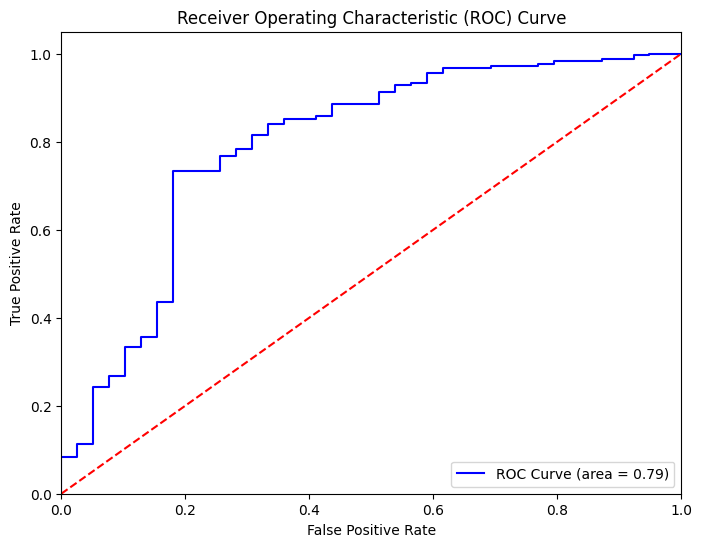

In [165]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [166]:
# Drop Insignificant Variables
df_sig = df_scaled.drop(columns = ['stock_option_level', 'training_times_last_year', 'avrg_years_per_comp', 'correct_field_of_study'])

# Logistic Regression Model
X_sig = df_sig.drop(columns=['retention'])
y_sig = df_sig['retention']

X_sig_train, X_sig_test, y_sig_train, y_sig_test = train_test_split(X_sig, y_sig, test_size=0.2, random_state=42)
X_sig_train_sm = sm.add_constant(X_sig_train)

logistic_model_sig = LogisticRegression(max_iter=1000)

logistic_model_sig.fit(X_sig_train, y_sig_train)

y_sig_pred = logistic_model_sig.predict(X_sig_test)
y_sig_pred_prob = logistic_model_sig.predict_proba(X_sig_test)[:, 1]

accuracy_sig = accuracy_score(y_sig_test, y_sig_pred)
accuracy_sig_df = pd.DataFrame({'Accuracy': [accuracy_sig]})

confusion_sig = confusion_matrix(y_sig_test, y_sig_pred)
conf_matrix_sig_df = pd.DataFrame(confusion_sig, columns=['Predicted No', 'Predicted Yes'], index=['Actual No', 'Actual Yes'])

report_sig = classification_report(y_sig_test, y_sig_pred, output_dict=True)
classification_sig_df = pd.DataFrame(report_sig).transpose()

display(accuracy_sig_df)

print('Confusion Matrix:')
display(conf_matrix_sig_df)

print('Classification Report:')
display(classification_sig_df)

logistic_model_sig = sm.Logit(y_sig_train, X_sig_train_sm)
result_sig = logistic_model_sig.fit()

display(result_sig.summary())

,Accuracy
0,0.87415


Confusion Matrix:


,Predicted No,Predicted Yes
Actual No,12,27
Actual Yes,10,245


Classification Report:


,precision,recall,f1-score,support
0,0.545455,0.307692,0.393443,39.00000
1,0.900735,0.960784,0.929791,255.00000
accuracy,0.874150,0.874150,0.874150,0.87415
macro avg,0.723095,0.634238,0.661617,294.00000
weighted avg,0.853606,0.874150,0.858643,294.00000


Optimization terminated successfully.
         Current function value: 0.299462
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              retention   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1149
Method:                           MLE   Df Model:                           26
Date:                Wed, 02 Oct 2024   Pseudo R-squ.:                  0.3394
Time:                        20:10:45   Log-Likelihood:                -352.17
converged:                       True   LL-Null:                       -533.07
Covariance Type:            nonrobust   LLR p-value:                 7.497e-61
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.7706      0.859     -0.898      0.369      -2.453       0.912
age                                1.7362      0.567      3.063      0.002       0.625       2.847
gender                            -0.4674      0.204     -2.295      0.022      -0.867      -0.068
education                         -0.0562      0.095     -0.593      0.553      -0.242       0.130
distance_from_home                -1.1741      0.332     -3.537      0.000      -1.825      -0.524
monthly_income                    -0.2604      1.111     -0.234      0.815      -2.437       1.917
percent_salary_hike                0.3197      0.381      0.840      0.401      -0.426       1.066
business_travel                   -0.8689      0.191     -4.538      0.000      -1.244      -0.494
over_time                         -2.1234      0.214     -9.928      0.000      -2.543      -1.704
job_satisfaction                   0.4138      0.089      4.640      0.000       0.239       0.589
job_involvement                    0.5195      0.135      3.852      0.000       0.255       0.784
relationship_satisfaction          0.1452      0.091      1.604      0.109      -0.032       0.323
environment_satisfaction           0.3556      0.092      3.880      0.000       0.176       0.535
work_life_balance                  0.3714      0.141      2.637      0.008       0.095       0.647
num_companies_worked              -1.6296      0.368     -4.433      0.000      -2.350      -0.909
years_since_last_promotion        -2.6953      0.640     -4.213      0.000      -3.949      -1.441
years_in_current_role              3.1823      0.734      4.335      0.000       1.743       4.621
status_divorced                    0.5507      0.285      1.933      0.053      -0.008       1.109
status_single                     -1.0900      0.216     -5.042      0.000      -1.514      -0.666
role_healthcare_representative     1.7841      0.544      3.277      0.001       0.717       2.851
role_human_resources              -0.8115      0.504     -1.609      0.108      -1.800       0.177
role_laboratory_technician        -0.6348      0.350     -1.811      0.070      -1.322       0.052
role_manager                       1.0579      0.812      1.303      0.192      -0.533       2.649
role_manufacturing_director        0.9392      0.478      1.966      0.049       0.003       1.876
role_research_director             2.6634      0.990      2.689      0.007       0.722       4.605
role_research_scientist            0.2839      0.355      0.799      0.424      -0.413       0.980
role_sales_representative         -1.2999      0.427     -3.046      0.002      -2.136      -0.463
==================================================================================================
"""

In [167]:
# Calculate VIF

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns

vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif_data

,Feature,VIF
0,age,8.669701
1,gender,2.542806
2,education,9.154322
3,distance_from_home,2.051207
4,monthly_income,15.416440
5,percent_salary_hike,2.342539
6,stock_option_level,3.400601
7,business_travel,5.246025
8,training_times_last_year,5.523110
9,over_time,1.452200


In [168]:
# Drop High VIF Variables
df_vif = df_scaled.drop(columns = ['age', 'monthly_income', 'job_involvement', 'work_life_balance'])

# Logistic Reg Model
X_vif = df_vif.drop(columns=['retention'])
y_vif = df_vif['retention']

X_vif_train, X_vif_test, y_vif_train, y_vif_test = train_test_split(X_vif, y_vif, test_size=0.2, random_state=42)
X_vif_train_sm = sm.add_constant(X_vif_train)

logistic_model_vif = LogisticRegression(max_iter=1000)

logistic_model_vif.fit(X_vif_train, y_vif_train)

y_vif_pred = logistic_model_vif.predict(X_vif_test)
y_vif_pred_prob = logistic_model_vif.predict_proba(X_vif_test)[:, 1]

accuracy_vif = accuracy_score(y_vif_test, y_vif_pred)
accuracy_vif_df = pd.DataFrame({'Accuracy': [accuracy_vif]})

confusion_vif = confusion_matrix(y_vif_test, y_vif_pred)
conf_matrix_vif_df = pd.DataFrame(confusion_vif, columns=['Predicted No', 'Predicted Yes'], index=['Actual No', 'Actual Yes'])

report_vif = classification_report(y_vif_test, y_vif_pred, output_dict=True)
classification_vif_df = pd.DataFrame(report_vif).transpose()

display(accuracy_vif_df)

print('Confusion Matrix:')
display(conf_matrix_vif_df)

print('Classification Report:')
display(classification_vif_df)

logistic_model_vif = sm.Logit(y_vif_train, X_vif_train_sm)
result_vif = logistic_model_vif.fit()

display(result_vif.summary())

,Accuracy
0,0.860544


Confusion Matrix:


,Predicted No,Predicted Yes
Actual No,8,31
Actual Yes,10,245


Classification Report:


,precision,recall,f1-score,support
0,0.444444,0.205128,0.280702,39.000000
1,0.887681,0.960784,0.922787,255.000000
accuracy,0.860544,0.860544,0.860544,0.860544
macro avg,0.666063,0.582956,0.601744,294.000000
weighted avg,0.828884,0.860544,0.837613,294.000000


Optimization terminated successfully.
         Current function value: 0.310232
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              retention   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1149
Method:                           MLE   Df Model:                           26
Date:                Wed, 02 Oct 2024   Pseudo R-squ.:                  0.3156
Time:                        20:10:45   Log-Likelihood:                -364.83
converged:                       True   LL-Null:                       -533.07
Covariance Type:            nonrobust   LLR p-value:                 9.989e-56
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.9209      0.684      1.346      0.178      -0.420       2.262
gender                            -0.4320      0.200     -2.163      0.031      -0.823      -0.041
education                         -0.0042      0.093     -0.045      0.964      -0.186       0.178
distance_from_home                -1.0649      0.325     -3.278      0.001      -1.702      -0.428
percent_salary_hike                0.3157      0.374      0.843      0.399      -0.418       1.049
stock_option_level                 0.2424      0.160      1.518      0.129      -0.071       0.555
business_travel                   -0.8027      0.188     -4.267      0.000      -1.171      -0.434
training_times_last_year           0.8127      0.467      1.739      0.082      -0.103       1.729
over_time                         -2.0479      0.209     -9.821      0.000      -2.457      -1.639
job_satisfaction                   0.3835      0.087      4.407      0.000       0.213       0.554
relationship_satisfaction          0.1938      0.089      2.174      0.030       0.019       0.369
environment_satisfaction           0.3557      0.090      3.936      0.000       0.179       0.533
num_companies_worked              -0.9255      0.404     -2.293      0.022      -1.717      -0.135
years_since_last_promotion        -2.8716      0.637     -4.510      0.000      -4.120      -1.624
years_in_current_role              3.1237      0.766      4.075      0.000       1.621       4.626
avrg_years_per_comp                0.0658      0.050      1.323      0.186      -0.032       0.163
correct_field_of_study            -0.0210      0.264     -0.079      0.937      -0.539       0.497
status_divorced                    0.3871      0.290      1.336      0.182      -0.181       0.955
status_single                     -0.9071      0.261     -3.473      0.001      -1.419      -0.395
role_healthcare_representative     1.7634      0.554      3.184      0.001       0.678       2.849
role_human_resources              -0.5584      0.473     -1.180      0.238      -1.486       0.369
role_laboratory_technician        -0.6315      0.298     -2.121      0.034      -1.215      -0.048
role_manager                       1.1807      0.621      1.902      0.057      -0.036       2.398
role_manufacturing_director        0.9765      0.490      1.994      0.046       0.017       1.937
role_research_director             2.6492      0.835      3.173      0.002       1.013       4.285
role_research_scientist            0.3212      0.308      1.044      0.296      -0.282       0.924
role_sales_representative         -1.2388      0.373     -3.318      0.001      -1.971      -0.507
==================================================================================================
"""

In [169]:
# Adjusted Coefficients for Continuous Variables
scaled_vars = [
    'age', 
    'distance_from_home', 
    'monthly_income', 
    'percent_salary_hike', 
    'training_times_last_year', 
    'num_companies_worked', 
    'years_since_last_promotion', 
    'years_in_current_role'
]

coefficients = result.params

# Min and Max Values
min_values = df.min()
max_values = df.max()

adjusted_coefficients = {}
for feature in scaled_vars:
    if feature in coefficients:
        coef = coefficients[feature]
        range_val = max_values[feature] - min_values[feature]
        
        adjusted_coef = coef / range_val if range_val != 0 else 0
      
        adjusted_coefficients[feature] = adjusted_coef

adjusted_coefficients_df = pd.DataFrame(list(adjusted_coefficients.items()), columns=['Variable', 'Adjusted Coefficient'])

adjusted_coefficients_df

,Variable,Adjusted Coefficient
0,age,0.038727
1,distance_from_home,-0.042981
2,monthly_income,-0.000017
3,percent_salary_hike,0.022682
4,training_times_last_year,0.144459
5,num_companies_worked,-0.164380
6,years_since_last_promotion,-0.181183
7,years_in_current_role,0.172278


In [170]:
# Odd Ratios
adjusted_odds_ratios = np.exp(adjusted_coefficients_df['Adjusted Coefficient'])

remaining_params = result.params.drop(adjusted_coefficients_df['Variable'], errors='ignore')

remaining_odds_ratios = np.exp(remaining_params)

combined_odds_ratios = adjusted_coefficients_df.copy()
combined_odds_ratios['Odds Ratio'] = adjusted_odds_ratios

remaining_odds_ratios_df = pd.DataFrame({
    'Variable': remaining_params.index,
    'Coefficient': remaining_params.values,
    'Odds Ratio': remaining_odds_ratios
})

combined_odds_ratios = pd.concat([combined_odds_ratios, remaining_odds_ratios_df], ignore_index=True)

final_columns_order = ['Variable', 'Adjusted Coefficient', 'Coefficient', 'Odds Ratio']
combined_odds_ratios = combined_odds_ratios[final_columns_order]

display(combined_odds_ratios)

,Variable,Adjusted Coefficient,Coefficient,Odds Ratio
0,age,0.038727,NaN,1.039487
1,distance_from_home,-0.042981,NaN,0.957930
2,monthly_income,-0.000017,NaN,0.999983
3,percent_salary_hike,0.022682,NaN,1.022941
4,training_times_last_year,0.144459,NaN,1.155414
5,num_companies_worked,-0.164380,NaN,0.848420
6,years_since_last_promotion,-0.181183,NaN,0.834283
7,years_in_current_role,0.172278,NaN,1.188008
8,const,NaN,-1.369664,0.254192
9,gender,NaN,-0.462337,0.629810
